# **Prepare datasets**

Kita akan memakai dataset NusaX dari paper [berikut](https://arxiv.org/pdf/2205.15960.pdf). Dataset bisa diunduh di [sini](https://drive.google.com/drive/folders/1z1V_dGuEgjZJ2RiauaEcGLkHjBMAwcuO?usp=sharing). Di dalamnya terdapat "train.csv", "valid.csv", dan "test.csv". 

Setelah kita download dataset, kita upload ke Google Colab. Setelah itu kita panggil dengan Pandas dan karena file nya terpisah, kita gabung menjadi 1. 

In [1]:
import pandas as pd

df_train = pd.read_csv('/content/train.csv')
df_valid = pd.read_csv('/content/valid.csv')

df = df_train.append(df_valid, ignore_index=True)

In [2]:
df_test = pd.read_csv('/content/test.csv')

df = df.append(df_test, ignore_index=True)

Kita cek isi datasetnya dan di dalamnya terdapat 1000 data. Terdiri dari:


*   Positive: 378
*   Neutral: 239
*   Negative: 383



In [3]:
df.head()

,id,text,label
0,219,Nikmati cicilan 0% hingga 12 bulan untuk pemes...,neutral
1,209,Kue-kue yang disajikan bikin saya bernostalgia...,positive
2,436,Ibu pernah bekerja di grab indonesia,neutral
3,394,Paling suka banget makan siang di sini ayam sa...,positive
4,592,Pelayanan bus DAMRI sangat baik,positive


In [4]:
df.shape

(1000, 3)

In [5]:
df.label.value_counts()

negative    383
positive    378
neutral     239
Name: label, dtype: int64

# **Text Normalization/Cleansing**

Lalu kita lakukan cleansing sebagai berikut

In [6]:
import re 

def cleansing(sent):
    # Mengubah kata menjadi huruf kecil semua dengan menggunakan fungsi lower()
    string = sent.lower()
    # Menghapus emoticon dan tanda baca menggunakan "RegEx" dengan script di bawah
    string = re.sub(r'[^a-zA-Z0-9]', ' ', string)
    return string

In [7]:
df['text_clean'] = df.text.apply(cleansing)

In [8]:
df.head()

,id,text,label,text_clean
0,219,Nikmati cicilan 0% hingga 12 bulan untuk pemes...,neutral,nikmati cicilan 0 hingga 12 bulan untuk pemes...
1,209,Kue-kue yang disajikan bikin saya bernostalgia...,positive,kue kue yang disajikan bikin saya bernostalgia...
2,436,Ibu pernah bekerja di grab indonesia,neutral,ibu pernah bekerja di grab indonesia
3,394,Paling suka banget makan siang di sini ayam sa...,positive,paling suka banget makan siang di sini ayam sa...
4,592,Pelayanan bus DAMRI sangat baik,positive,pelayanan bus damri sangat baik


Sortir data dan label berdasarkan sentimen

In [9]:
neg = df.loc[df['label'] == 'negative'].text_clean.tolist()
neu = df.loc[df['label'] == 'neutral'].text_clean.tolist()
pos = df.loc[df['label'] == 'positive'].text_clean.tolist()

neg_label = df.loc[df['label'] == 'negative'].label.tolist()
neu_label = df.loc[df['label'] == 'neutral'].label.tolist()
pos_label = df.loc[df['label'] == 'positive'].label.tolist()

In [10]:
total_data = pos + neu + neg
labels = pos_label + neu_label + neg_label

print("Pos: %s, Neu: %s, Neg: %s" % (len(pos), len(neu), len(neg)))
print("Total data: %s" % len(total_data))

Pos: 378, Neu: 239, Neg: 383
Total data: 1000


# **Feature Extraction**

Setelah itu kita lakukan Feature Extraction menggunakan modul "Tokenizer" dan "pad_sequences" dari Tensorflow. 

Module Tokenizer memungkinkan untuk memvektorisasi korpus teks, dengan mengubah setiap teks menjadi urutan bilangan bulat (setiap bilangan bulat menjadi indeks token dalam kamus) atau menjadi vektor di mana koefisien untuk setiap token bisa biner, berdasarkan jumlah kata , berdasarkan tf-idf.

Module pad_sequences memungkinkan mengubah list dari sequences menjadi array bentuk 2D.

In [11]:
import pickle
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from collections import defaultdict

max_features = 100000
tokenizer = Tokenizer(num_words=max_features, split=' ', lower=True)
tokenizer.fit_on_texts(total_data)
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
    print("tokenizer.pickle has created!")

X = tokenizer.texts_to_sequences(total_data)

vocab_size = len(tokenizer.word_index)
maxlen = max(len(x) for x in X)

X = pad_sequences(X)
with open('x_pad_sequences.pickle', 'wb') as handle:
    pickle.dump(X, handle, protocol=pickle.HIGHEST_PROTOCOL)
    print("x_pad_sequences.pickle has created!")

tokenizer.pickle has created!
x_pad_sequences.pickle has created!


In [12]:
Y = pd.get_dummies(labels)
Y = Y.values

with open('y_labels.pickle', 'wb') as handle:
    pickle.dump(Y, handle, protocol=pickle.HIGHEST_PROTOCOL)
    print("y_labels.pickle has created!")

y_labels.pickle has created!


# **Prepare train & test datasets/Splitting Dataset**

Split dataset menjadi 80% untuk train dan 20% untuk test.

In [13]:
from sklearn.model_selection import train_test_split

file = open("x_pad_sequences.pickle",'rb')
X = pickle.load(file)
file.close()

file = open("y_labels.pickle",'rb')
Y = pickle.load(file)
file.close()

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=1)

# **Training**

Jalankan training dengan metode LSTM. Arsitektur LSTM ini dibangun menggunakan framework Tensorflow.

In [14]:
import numpy as np
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, SpatialDropout1D, SimpleRNN, Activation
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
from tensorflow.keras.layers import Flatten
from tensorflow.keras import backend as K

Adapun arsitektur LSTM yang dibangun sebagai berikut:


*   Input Layer: Data teks setelah dilakukan Feature Extraction, dikondisikan menjadi sebuah matrix berdimensi 100. 
*   Unit Layer: Pada bagian ini diterapkan unit/neuron sejumlah 64. Pada tahap ini pula fitur Dropout diterapkan guna meminimalisir overfitting.
*   Fully-connected Layer: Setelah proses convolution, dikondisikan sebagai input untuk Multi-layer Perceptron terdiri dari 10 input dan 3 output. Pada tahap ini diimplementasikan pula aktivasi "softmax".

Untuk mencegah overfitting, kita menerapkan EarlyStopping. Sehingga, meskipun epoch belum selesai, training sudah selesai.

In [15]:
embed_dim = 100
units = 64

model = Sequential()
model.add(Embedding(max_features, embed_dim, input_length=X.shape[1]))
model.add(LSTM(units, dropout=0.2))
model.add(Dense(3,activation='softmax'))
model.compile(loss = 'binary_crossentropy', optimizer='adam',metrics = ['accuracy'])
print(model.summary())

adam = optimizers.Adam(lr = 0.001)
model.compile(loss = 'categorical_crossentropy', optimizer = adam, metrics = ['accuracy'])

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)
history = model.fit(X_train, y_train, epochs=10, batch_size=10, validation_data=(X_test, y_test), verbose=1, callbacks=[es])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 77, 100)           10000000  
                                                                 
 lstm (LSTM)                 (None, 64)                42240     
                                                                 
 dense (Dense)               (None, 3)                 195       
                                                                 
Total params: 10,042,435
Trainable params: 10,042,435
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10


/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


80/80 [==============================] - 8s 18ms/step - loss: 0.9093 - accuracy: 0.6050 - val_loss: 0.8184 - val_accuracy: 0.6550
Epoch 2/10
80/80 [==============================] - 1s 12ms/step - loss: 0.5075 - accuracy: 0.8188 - val_loss: 0.6312 - val_accuracy: 0.7950
Epoch 2: early stopping


# Evaluation

## Confussion Matrix, Accuracy, F1, Recall, Precision

Langkah selanjutnya adalah "Evaluation". Module "classification_report" dari Sklearn merupakan salah satu modul untuk melakukan "Evaluation". Pada tahap evaluasi ini kita akan menerapkan metode evaluasi Accuracy, Precision, Recall dan F1-Score.

In [16]:
from sklearn import metrics

predictions = model.predict(X_test)
y_pred = predictions
matrix_test = metrics.classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1))
print("Testing selesai")
print(matrix_test)

7/7 [==============================] - 0s 4ms/step
Testing selesai
              precision    recall  f1-score   support

           0       0.71      0.93      0.80        73
           1       0.84      0.59      0.70        54
           2       0.89      0.81      0.85        73

    accuracy                           0.80       200
   macro avg       0.81      0.78      0.78       200
weighted avg       0.81      0.80      0.79       200



Hasilnya nilai F1 Score ada pada angka 0.76 untuk Negative, 0.59 untuk Neutral, dan 0.83 untuk Positive. Hasil ini bisa dikatakan cukup bagus untuk sebuah model, namun kecenderungan untuk memilih sentimen netralnya lemah.

## Cross Validation

Mekanisme evaluasi selanjutnya menggunakan "Cross Validation", yaitu merotasi porsi testing dari dataset agar bisa melihat model yang sudah kita buat stabil ketika dihadapkan pada data yang berbeda.

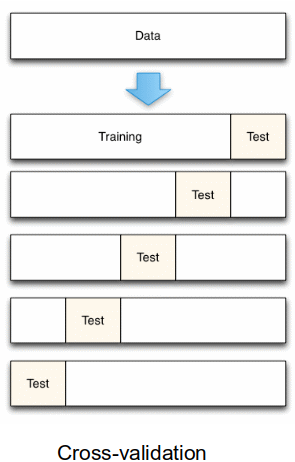

In [17]:
# Untuk lebih menyakinkan lagi, kita juga bisa melakukan "Cross Validation"
import numpy as np
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold

kf = KFold(n_splits=5,random_state=42,shuffle=True)

accuracies = []

y = Y

embed_dim = 100
units = 64

for iteration, data in enumerate(kf.split(X), start=1):

    data_train   = X[data[0]]
    target_train = y[data[0]]

    data_test    = X[data[1]]
    target_test  = y[data[1]]


    model = Sequential()
    model.add(Embedding(max_features, embed_dim, input_length=X.shape[1]))
    model.add(LSTM(units, dropout=0.2))
    model.add(Dense(3,activation='softmax'))
    model.compile(loss = 'binary_crossentropy', optimizer='adam',metrics = ['accuracy'])

    adam = optimizers.Adam(lr = 0.001)
    model.compile(loss = 'categorical_crossentropy', optimizer = adam, metrics = ['accuracy'])

    es = EarlyStopping(monitor='val_loss', mode='min', verbose=0)
    history = model.fit(X_train, y_train, epochs=10, batch_size=10, validation_data=(X_test, y_test), verbose=0, callbacks=[es])

    predictions = model.predict(X_test)
    y_pred = predictions

    # for the current fold only    
    accuracy = accuracy_score(y_test.argmax(axis=1), y_pred.argmax(axis=1))

    print("Training ke-", iteration)
    print(classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1)))
    print("======================================================")

    accuracies.append(accuracy)

# this is the average accuracy over all folds
average_accuracy = np.mean(accuracies)

print()
print()
print()
print("Rata-rata Accuracy: ", average_accuracy)

/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


7/7 [==============================] - 0s 4ms/step
Training ke- 1
              precision    recall  f1-score   support

           0       0.70      0.85      0.77        73
           1       0.83      0.63      0.72        54
           2       0.85      0.82      0.83        73

    accuracy                           0.78       200
   macro avg       0.79      0.77      0.77       200
weighted avg       0.79      0.78      0.78       200



/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


7/7 [==============================] - 0s 4ms/step
Training ke- 2
              precision    recall  f1-score   support

           0       0.75      0.79      0.77        73
           1       0.77      0.61      0.68        54
           2       0.80      0.88      0.84        73

    accuracy                           0.78       200
   macro avg       0.77      0.76      0.76       200
weighted avg       0.77      0.78      0.77       200



/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


7/7 [==============================] - 0s 4ms/step
Training ke- 3
              precision    recall  f1-score   support

           0       0.80      0.81      0.80        73
           1       0.75      0.67      0.71        54
           2       0.81      0.86      0.83        73

    accuracy                           0.79       200
   macro avg       0.78      0.78      0.78       200
weighted avg       0.79      0.79      0.79       200



/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


7/7 [==============================] - 0s 4ms/step
Training ke- 4
              precision    recall  f1-score   support

           0       0.78      0.73      0.75        73
           1       0.64      0.70      0.67        54
           2       0.82      0.82      0.82        73

    accuracy                           0.76       200
   macro avg       0.75      0.75      0.75       200
weighted avg       0.76      0.76      0.76       200



/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


7/7 [==============================] - 0s 4ms/step
Training ke- 5
              precision    recall  f1-score   support

           0       0.78      0.73      0.75        73
           1       0.72      0.61      0.66        54
           2       0.77      0.90      0.83        73

    accuracy                           0.76       200
   macro avg       0.75      0.75      0.75       200
weighted avg       0.76      0.76      0.76       200




Rata-rata Accuracy:  0.772


Hasilnya nilai rata-rata accuracy pada angka 0.75. Ini menunjukkan model kita cukup stabil pada angka 0.75.

## Visualization

Mekanisme evaluasi selanjutnya menggunakan "Visualization", yaitu mengecek performa training dari arah visualisasinya. Acuan apakah visualisasi bagus atau tidak "Good Fit", sebagai berikut:

**Overfitting**

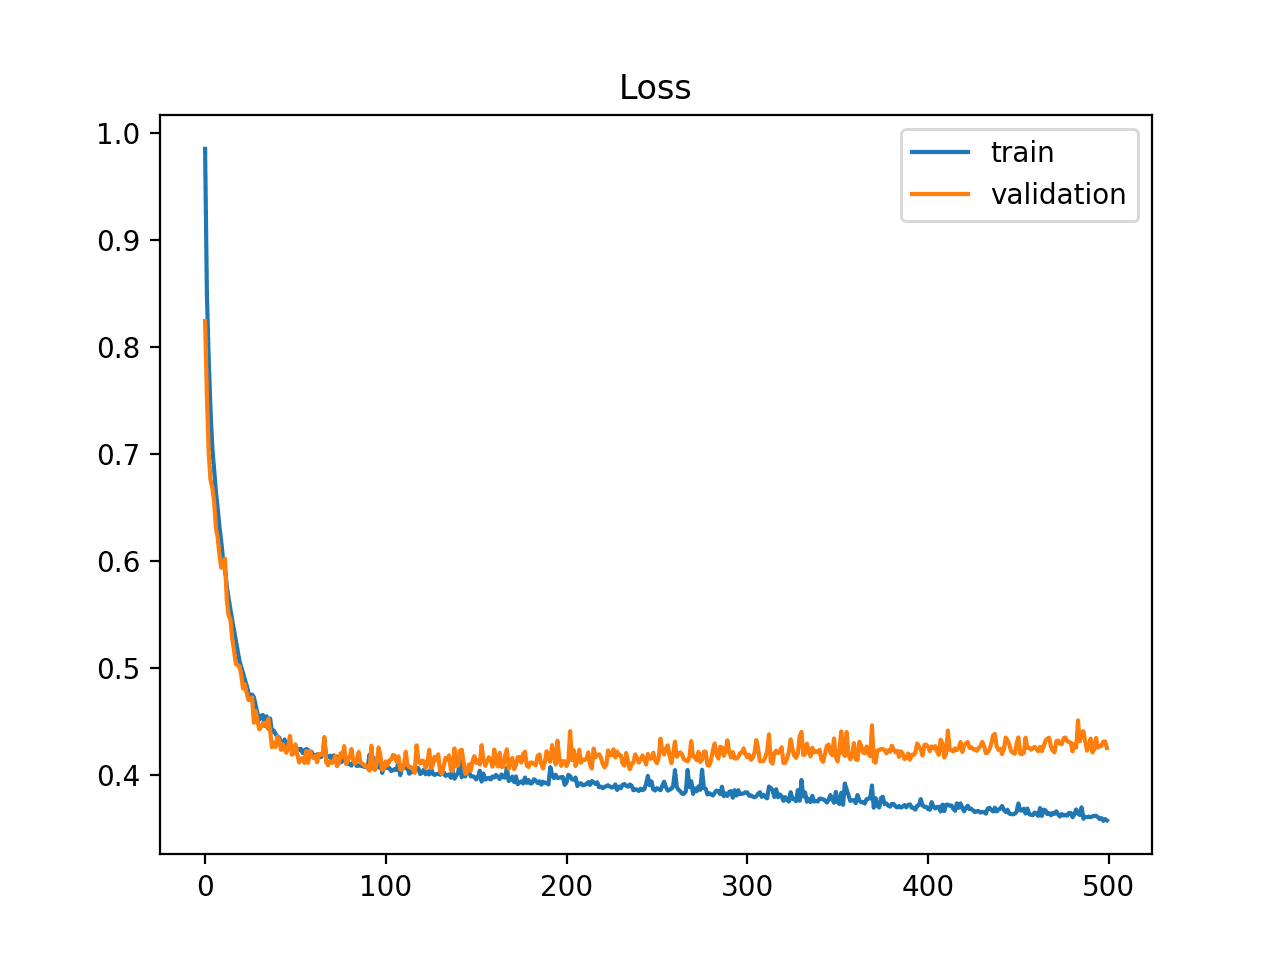

**Underfitting**
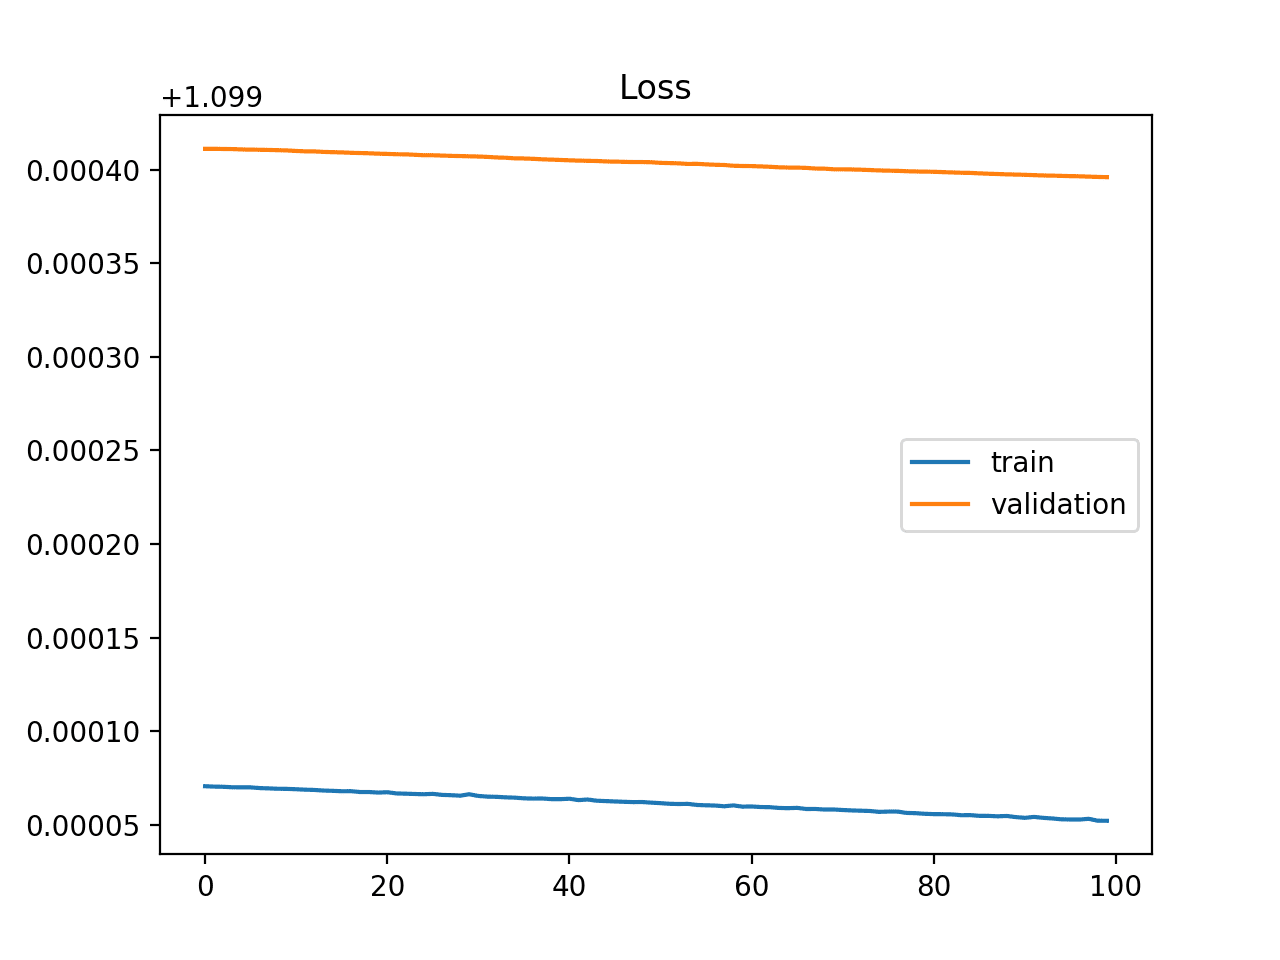

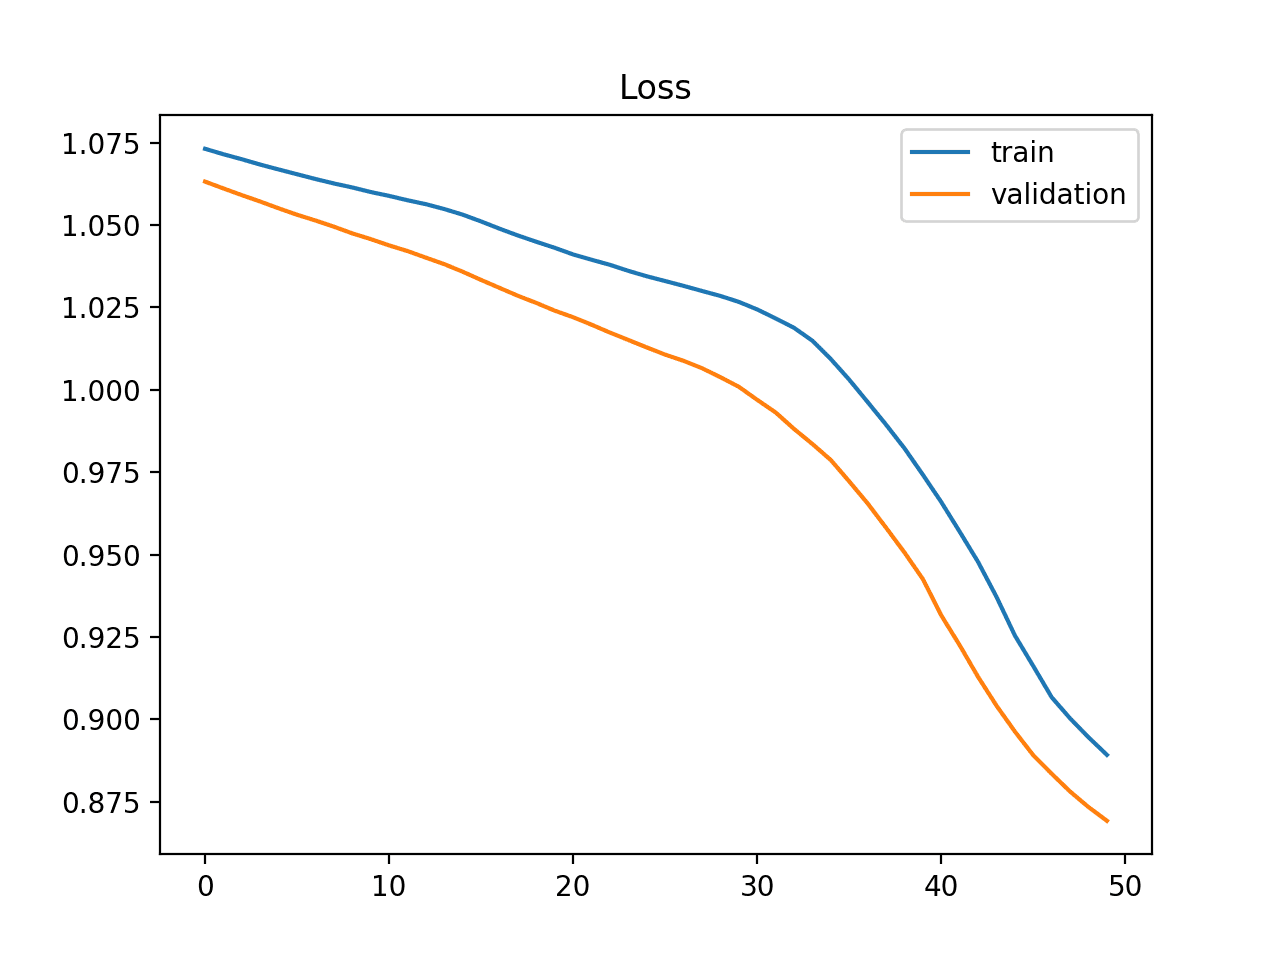

**Good Fit**

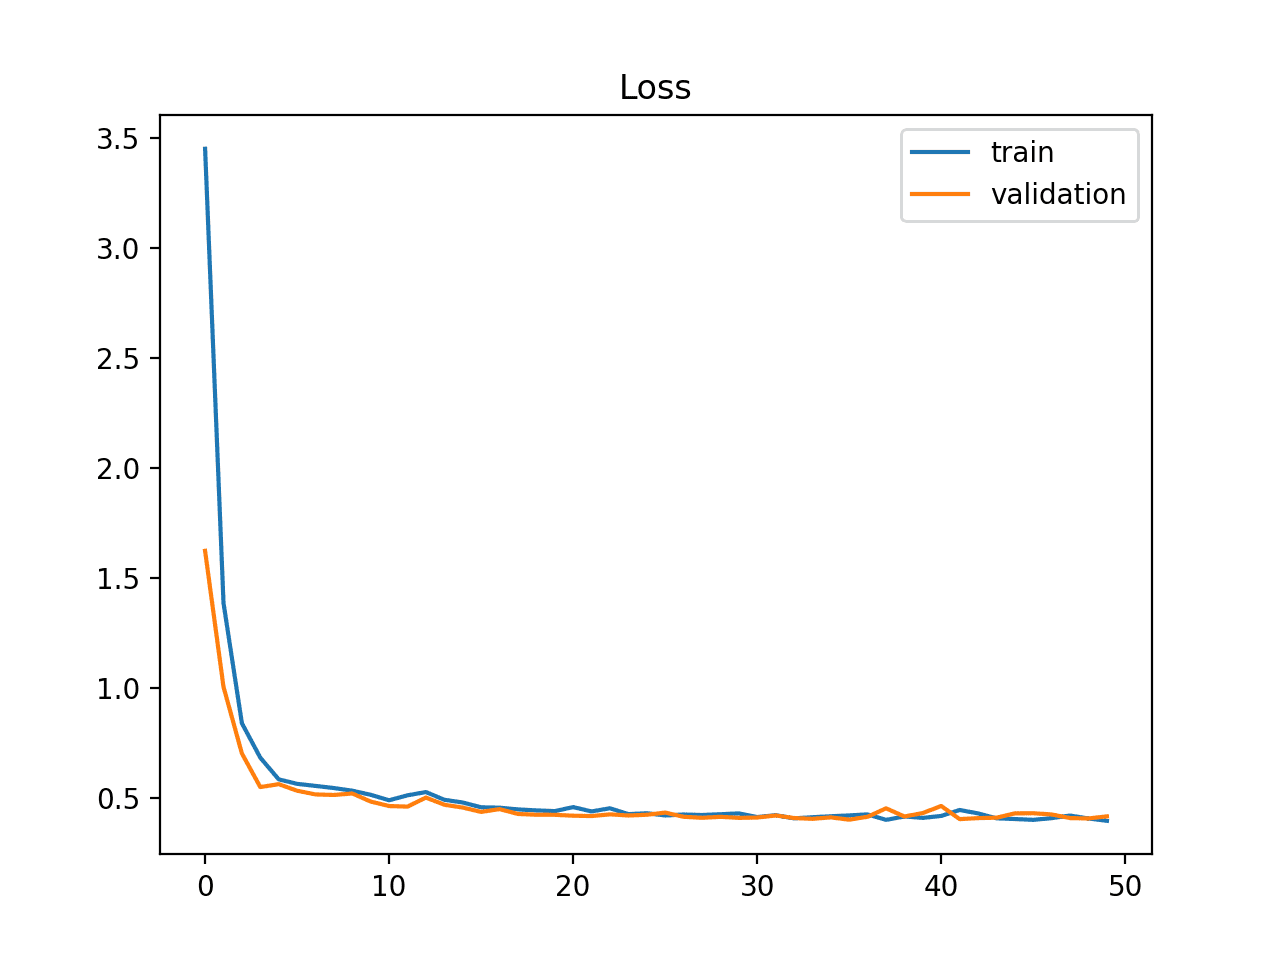

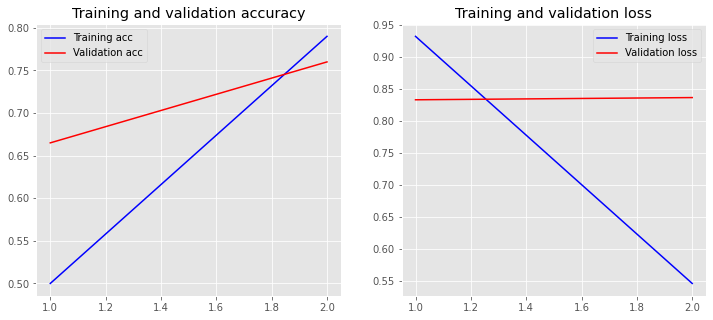

In [18]:
# history.history
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

%matplotlib inline
plot_history(history)

Hasilnya jika kita melihat visualisasinya model yang kita kembangkan tergolong Underfitting. Disinyalir karena:


*   Data training terlalu sedikit
*   Proses training berhenti terlalu cepat. Mungkin saja penerapan EarlyStopping untuk kasus kita tidak terlalu tepat



In [19]:
model.save('model.h5')
print("Model has created!")

Model has created!


# Predict

In [20]:
import re 
from keras.models import load_model

input_text = """
Rasa syukur, cukup.
"""

def cleansing(sent):
    # Mengubah kata menjadi huruf kecil semua dengan menggunakan fungsi lower()
    string = sent.lower()
    # Menghapus emoticon dan tanda baca menggunakan "RegEx" dengan script di bawah
    string = re.sub(r'[^a-zA-Z0-9]', ' ', string)
    return string

sentiment = ['negative', 'neutral', 'positive']

text = [cleansing(input_text)]
predicted = tokenizer.texts_to_sequences(text)
guess = pad_sequences(predicted, maxlen=X.shape[1])

model = load_model('model.h5')
prediction = model.predict(guess)
polarity = np.argmax(prediction[0])

print("Text: ",text[0])
print("Sentiment: ",sentiment[polarity])

1/1 [==============================] - 0s 326ms/step
Text:   rasa syukur  cukup  
Sentiment:  neutral
